<a href="https://colab.research.google.com/github/yannasyr/landcover/blob/main/yann_last_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [ ]:
!pip install timm
!pip install transformers

In [1]:
import os
import random
from timeit import default_timer as timer
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import (
    Compose,
    ToTensor,
    RandomVerticalFlip,
    RandomHorizontalFlip,
    Normalize,
    RandomRotation,
    ToPILImage,
)

from tifffile import TiffFile
from sklearn.model_selection import train_test_split
from transformers import SegformerModel, SegformerConfig, AutoImageProcessor, SegformerForSemanticSegmentation

# Utils from the github project

In [2]:
class LandCoverData():
    """Class to represent the S2GLC Land Cover Dataset for the challenge,
    with useful metadata and statistics.
    """
    # image size of the images and label masks
    IMG_SIZE = 256
    # the images are RGB+NIR (4 channels)
    N_CHANNELS = 4
    # we have 9 classes + a 'no_data' class for pixels with no labels (absent in the dataset)
    N_CLASSES = 10
    CLASSES = [
        'no_data',
        'clouds',
        'artificial',
        'cultivated',
        'broadleaf',
        'coniferous',
        'herbaceous',
        'natural',
        'snow',
        'water'
    ]
    # classes to ignore because they are not relevant. "no_data" refers to pixels without
    # a proper class, but it is absent in the dataset; "clouds" class is not relevant, it
    # is not a proper land cover type and images and masks do not exactly match in time.
    IGNORED_CLASSES_IDX = [0, 1]

    # The training dataset contains 18491 images and masks
    # The test dataset contains 5043 images and masks
    TRAINSET_SIZE = 18491
    TESTSET_SIZE = 5043

    # for visualization of the masks: classes indices and RGB colors
    CLASSES_COLORPALETTE = {
        0: [0,0,0],
        1: [255,25,236],
        2: [215,25,28],
        3: [211,154,92],
        4: [33,115,55],
        5: [21,75,35],
        6: [118,209,93],
        7: [130,130,130],
        8: [255,255,255],
        9: [43,61,255]
        }
    CLASSES_COLORPALETTE = {c: np.asarray(color) for (c, color) in CLASSES_COLORPALETTE.items()}

    # statistics
    # the pixel class counts in the training set
    TRAIN_CLASS_COUNTS = np.array(
        [0, 20643, 60971025, 404760981, 277012377, 96473046, 333407133, 9775295, 1071, 29404605]
    )
    # the minimum and maximum value of image pixels in the training set
    TRAIN_PIXELS_MIN = 1
    TRAIN_PIXELS_MAX = 24356

In [3]:
def numpy_parse_image_mask(image_path):
    """Load an image and its segmentation mask as numpy arrays and returning a tuple
    Args:
        image_path : path to image
    Returns:
        (numpy.array[uint16], numpy.array[uint8]): the image and mask arrays
    """
    # image_path = Path(image_path)
    # get mask path from image path:
    # image should be in a images/<image_id>.tif subfolder, while the mask is at masks/<image_id>.tif
    mask_path = image_path.replace("images","masks")
    with TiffFile(image_path) as tifi, TiffFile(mask_path) as tifm:
        image = tifi.asarray()
        mask = tifm.asarray()
        # add channel dimension to mask: (256, 256, 1)
        # mask = mask[..., None]
    return image, mask


# Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
class LandscapeData(Dataset):

    N_CHANNELS = LandCoverData.N_CHANNELS
    IMG_SIZE = LandCoverData.IMG_SIZE
    TRAIN_PIXELS_MAX = LandCoverData.TRAIN_PIXELS_MAX

    def __init__(self, data_folder, transform=ToTensor()):
        self.data_folder = data_folder
        self.transform = transform

        # Liste des noms de fichiers dans les dossiers
        image_files = os.listdir(os.path.join(data_folder, 'images'))

        # Séparation des données en ensembles d'entraînement, de validation et de test
        train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
        train_files, val_files = train_test_split(train_files, test_size=0.1, random_state=42)

        # Utilisez numpy_parse_image_mask pour charger les images et les masques
        self.train_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in train_files]
        self.val_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in val_files]
        self.test_data = [numpy_parse_image_mask(os.path.join(data_folder, 'images', filename)) for filename in test_files]

    def __len__(self):
        return len(self.train_data)

    def __getitem__(self, idx):
        image, label = self.train_data[idx]
        channels, height, width = self.N_CHANNELS, self.IMG_SIZE, self.IMG_SIZE

        # Normalisez les valeurs des pixels dans la plage [0, 1]
        image = image.astype("float32") / self.TRAIN_PIXELS_MAX
        label = label.astype("int64")

        image = self.transform(image)

        # Modifiez la transformation pour le masque
        label = torch.tensor(label, dtype=torch.int64)  # Convertir en torch.Tensor
        label = label.squeeze()  # Supprimer la dimension ajoutée

        return image, label


# Exemple d'utilisation
data_folder = "/content/drive/MyDrive/Colab Notebooks/small_dataset_bis"
dataset = LandscapeData(data_folder, transform=transforms.Compose([transforms.ToTensor()]))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)


images, masks = next(iter(train_loader))
print("Image : ", images.shape)
print("masks : ", masks.shape)


Image :  torch.Size([4, 4, 256, 256])
masks :  torch.Size([4, 256, 256])


In [11]:
config = SegformerConfig(
    num_labels=10,
    num_channels=4,
)

model = SegformerForSemanticSegmentation(config)

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

model.train()
for epoch in range(200):  # loop over the dataset multiple times
   print("Epoch:", epoch)
   for inputs, targets in train_loader:
        # get the inputs;
        pixel_values = inputs.to('cuda:0')
        labels = targets.to('cuda:0')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

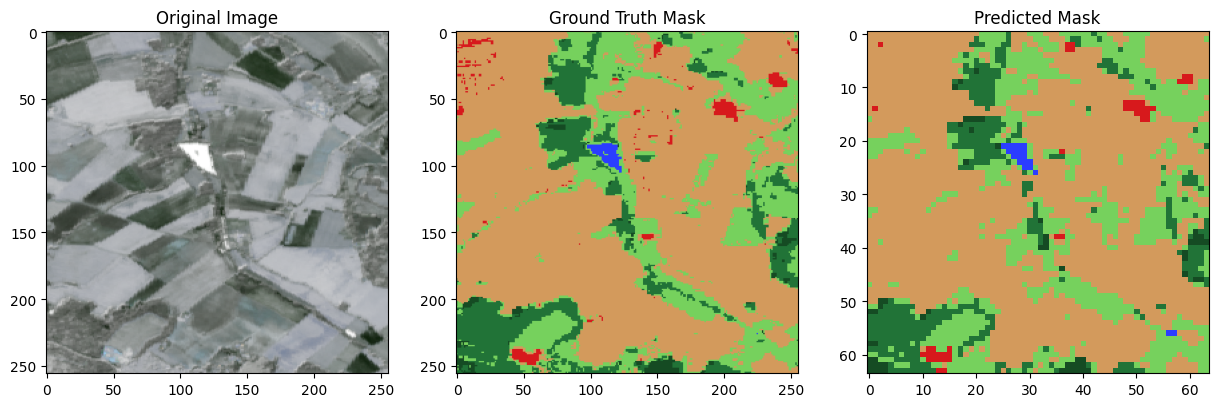

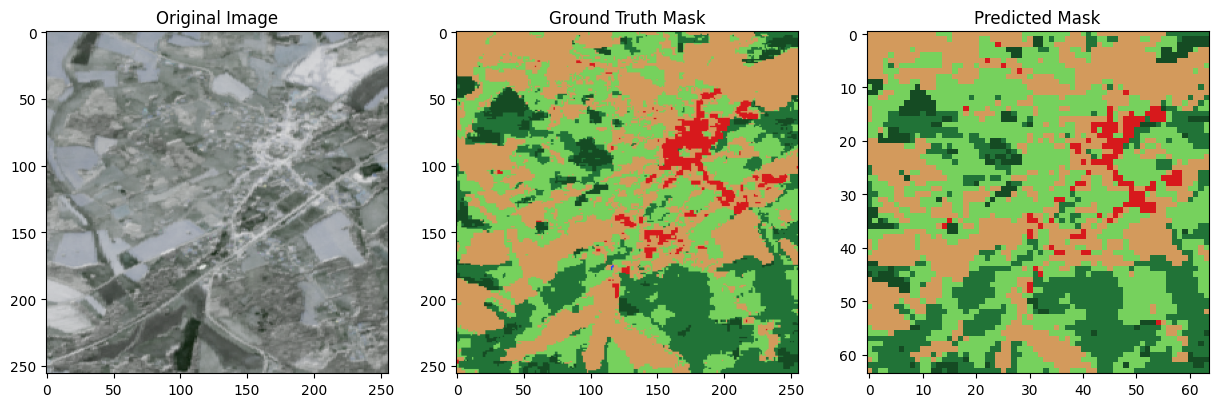

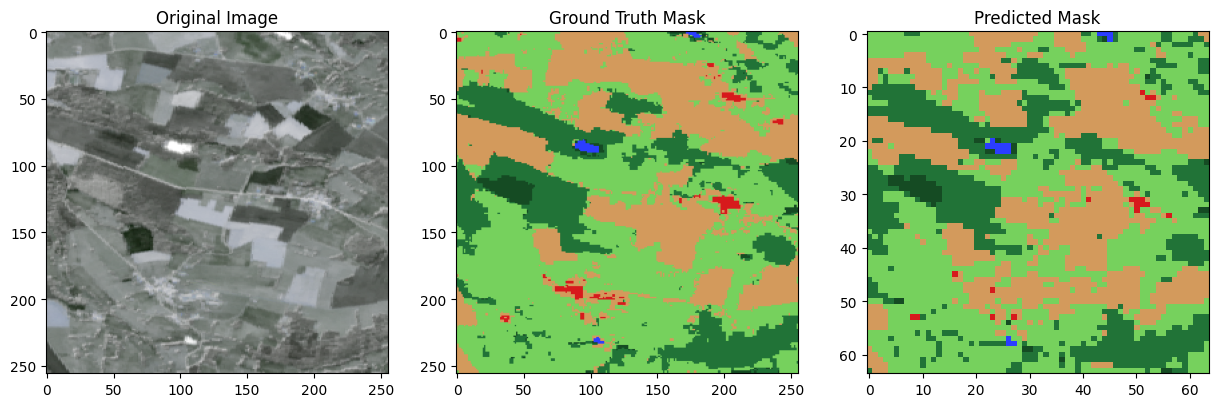

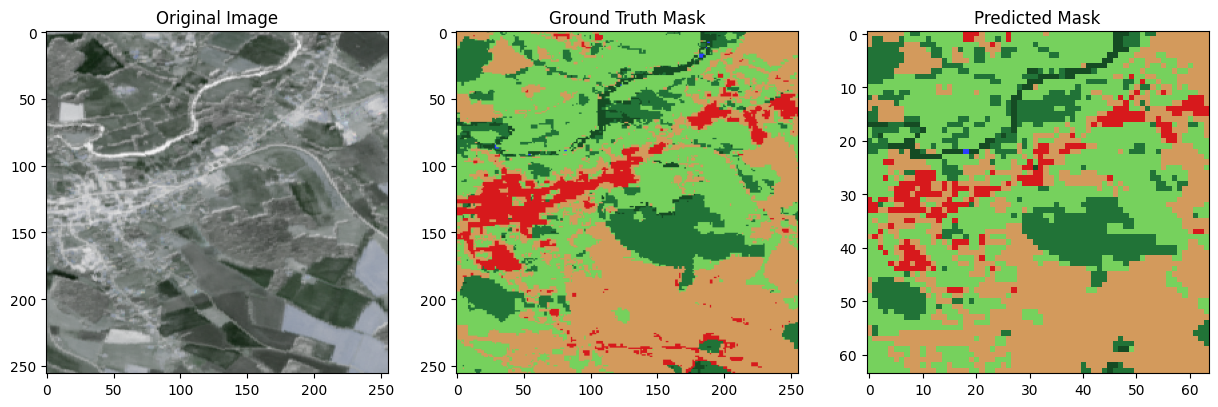

In [26]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Color palette
CLASSES_COLORPALETTE = {
    0: [0, 0, 0],
    1: [255, 25, 236],
    2: [215, 25, 28],
    3: [211, 154, 92],
    4: [33, 115, 55],
    5: [21, 75, 35],
    6: [118, 209, 93],
    7: [130, 130, 130],
    8: [255, 255, 255],
    9: [43, 61, 255]
}

# Assuming val_loader is defined in your code
val_inputs, val_targets = next(iter(val_loader))

val_pixel_values = val_inputs.to(device)

# Set the model to evaluation mode
model.eval()
# Perform inference on the validation image
with torch.no_grad():
    val_outputs = model(pixel_values=val_pixel_values)
    val_logits = val_outputs.logits

# Convert logits to predicted labels
_, predicted_labels = torch.max(val_logits, dim=1)

# Visualize the results for one image
for i in range(4):  # Assuming batch size is 4
    plt.figure(figsize=(15, 5))

    # Original image
    original_image = val_inputs[i].permute(1, 2, 0).cpu().numpy()
    original_image = original_image / original_image.max()  # Normalize to [0, 1]
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    # Ground truth mask
    plt.subplot(1, 3, 2)
    ground_truth_mask = val_targets[i].cpu().numpy()
    ground_truth_mask_rgb = np.zeros((ground_truth_mask.shape[0], ground_truth_mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASSES_COLORPALETTE.items():
        ground_truth_mask_rgb[ground_truth_mask == cls] = color
    plt.imshow(ground_truth_mask_rgb)
    plt.title("Ground Truth Mask")

    # Predicted mask
    plt.subplot(1, 3, 3)
    predicted_mask = predicted_labels[i].cpu().numpy()
    predicted_mask_rgb = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
    for cls, color in CLASSES_COLORPALETTE.items():
        predicted_mask_rgb[predicted_mask == cls] = color
    plt.imshow(predicted_mask_rgb)
    plt.title("Predicted Mask")

    plt.show()


In [23]:
# Estimation du vecteur Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
def get_Y(mask2d):
  """
  Estimation du vecteur contenant les proportions de chaque classe dans une image segmentée:
  Y = [no_data, clouds, artificial, cultivated, broadleaf, coniferous, herbaceous, natural, snow, water]
  """
  occurrences = np.bincount(mask2d.flatten(), minlength=10)
  Y = occurrences / np.sum(occurrences)
  return Y

def klmetric(y_t, y_p, eps):
  """
  Calcul de la divergence de Kullbach-Leiber
  Args:
    - y_t (np.array) : Le vecteur Ground Truth.
    - y_p (np.array) : Le vecteur des prédictions.
    - eps : epsilon dans la formule de K-L divergence.
  """
  sum = 0
  for i in range(len(y_t)):
    sum += (y_t[i]+eps)*np.log((y_t[i] + eps) / (y_p[i] + eps))
  return sum

In [24]:
def mesure_on_batch(batch_gt, batch_predi, batch_size=4):
  mean = 0
  for i in range(batch_size):
    Y_pred = get_Y(batch_gt[i].cpu().numpy())
    Y_truth = get_Y(batch_predi[i].cpu().numpy())
    mean += klmetric(Y_truth, Y_pred, 10e-8)
  return mean / batch_size

def mesure_on_dataloader(test_dataloader):
  """Implémentation de la mesure 'Kullbach-Leiber divergence'
  Args:
      test_dataloader (Dataloader): Le dataloader contenant le dataset de test.
  Returns:
      (float32): La valeur de KL-divergence.
  """
  mean = 0
  for i in range(len(test_dataloader)):
    test_inputs, test_targets = next(iter(val_loader))
    test_pixels_values = test_inputs.to(device)
    model.eval()
    with torch.no_grad():
      test_outputs = model(pixel_values=test_pixels_values)
      test_logits = test_outputs.logits

    _, predicted_labels = torch.max(test_logits, dim=1)

    mean += mesure_on_batch(test_targets, predicted_labels)

  return mean / len(test_dataloader)

In [25]:
kl = mesure_on_dataloader(val_loader)
print(f"Kullback–Leibler divergence on this dataset : {kl:.4f}")

Kullback–Leibler divergence on this dataset : 0.0058
